In [1]:
# Filtering Warnings

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from random import gauss
from pandas.plotting import autocorrelation_plot
import itertools
from random import random

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# import matplotlib as mpl
import seaborn as sns   

from tqdm.notebook import trange as notebook_trange
from tqdm import tqdm, trange
from pycaret.classification import*

# Vintage toolkit for modern times !

* Subgroups
    * Groundwork
    * Forecasting
    * Digging deeper
    * Anomaly detection
#    

# 
#DeepLearnEverything

In [2]:
# general settings
class CFG:
    data_folder = '../data/'
    img_dim1 = 20
    img_dim2 = 10
    
    
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})    

<a id="section-one"></a>
# Groundwork


TL;DR Time series is any sequence you record over time and applications are everywhere.

More formally, time series data is a sequence of data points (or observations) recorded at different time intervals - those intervals are frequently, but not always, regular (hourly, daily, weekly, monthly, quarterly etc): 


\begin{equation}
\{X_t\} \quad t= 1,\ldots,T 
\end{equation}


A strict formulation would be that a time series (discrete) realization of a (continuous) stochastic process generating the data and the underlying reason why we can infer from the former about the latter is the Kolmogorov extension theorem. The proper mathematical treatment of this theory is way beyond the scope of this notebook, so a mathematically inclinded reader is advised to look up those terms and then follow the references. 

Phenomena measured over time are everywhere, so a natural question is: what can we do with time series? Some of the more popular applications / reasons to bother are:

* interpretation: we want to be able to make sense of diverse phenomena and capture the nature of the underlying dynamics
* modelling: understanding inherent aspects of the time series data so that we can create meaningful and accurate forecasts.
* **forecasting / prediction**: we want to know something about the future :-) 
    * **My aim is predicting medical complications with time series. For example who will worsening during the septic shock at the Pediatric Intensive Care Unit (PICU)**
* filtering / smoothing: we want to get a better understanding of the process based on partially / fully observed sample
* simulation: in certain applications calculating e.g. high quantiles of a distribution is only possible with simulation, because there is not enough historical data

Some useful references include:

* Brockwell and Davies "Time Series: Theory and Methods"
* Shumway and Stoffer "Time Series Analysis and Its Applications"
* Durbin and Koopman "Time Series Analysis by State Space Methods"
* Just about anything written by **Rob Hyndman** https://robjhyndman.com/
* Ross Ihaka "Time Series Analysis": https://www.stat.auckland.ac.nz/~ihaka/726/notes.pdf

<a id="section-two"></a>
# Patterns

### Decomposition (additive):


The first we can do to identify patterns in a time series is separate it into components with easily understandable characteristics:

\begin{equation}
X_t = T_t + S_t + C_t + I_t \quad 
\end{equation}

Where: 
* $T_t$: the trend shows a general direction of the time series data over a long period of time. It represents a long-term progression of the series (secular variation)  

* $S_t$: the seasonal component with fixed and known period. It is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors: annual, monthly or weekly. Obvious examples include daily power consumption patterns or annual sales of seasonal goods.

* $C_t$: (optional) cyclical component is a repetitive pattern which does not occur at fixed intervals - usually observed in an economic context like business cycles. 

* $I_t$: the irregular component (residuals ) consists of the fluctuations in the time series that are observed after removing trend and seasonal / cyclical variations. 

*Examples:* -- I added

* $T_t$: Some of long term progression. For example, some new song comes, it goes trending for a while, and then disappears. There is fairly any chance that it would be trending again. For example some country 80 percent of people using the internet, and the population growing at 5 percent anually taking ridiculous number obviously. Then the number of users will also keep growing at that rate and it is pretty deterministic i mean it's not ideally deterministic of course but it is something that we can kinda capture that way.

* $S_t$: For example, sales of ice cream heavily seasonal, christmas article also.

* $C_t$: Economical conditions

* $I_t$: Noise

We may have different combinations of trends and seasonality. Depending on the nature of the trends and seasonality, a time series can be modeled as an additive or multiplicative time series. Each observation in the series can be expressed as either a sum or a product of the components.

### Decomposition (multiplicative):

It is worth pointing out that an alternative to using a multiplicative decomposition is to first transform the data until the variation in the series appears to be stable over time, then use an additive decomposition. When a log transformation has been used, this is equivalent to using a multiplicative decomposition because
\begin{equation}
X_t = T_t * S_t * I_t
\end{equation}

is equivalent to 

\begin{equation}
log X_t = log T_t + log S_t + log I_t
\end{equation}


A popular implementation for calculating the fundamental decomposition can be used via the statsmodels package:

## Examples

### Passengers dataset

Every field of knowledge has **the** dataset that is used for teaching purposes: machine learning has Iris and CIFAR, differential equations - Canadian lynx data, and statistics has the airline passengers dataset between 1949 and 1960, first compiled by Box and Jenkins (you will be hearing those two names again in the next module) in 1976. We will use this dataset to demonstrate in practice what kind of information can be obtained using seasonal decomposition.

<!-- Box, G. E. P., Jenkins, G. M. and Reinsel, G. C. (1976) Time Series Analysis, Forecasting and Control. Third Edition. Holden-Day. Series G. -->


*I added here --->*
#### Box & Jenkins method:
* In time series analysis, the Box–Jenkins method, named after the statisticians George Box and Gwilym Jenkins, applies autoregressive moving average (ARMA) or autoregressive integrated moving average (ARIMA) models to find the best fit of a time-series model to past values of a time series. 
* [Reference](https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method)

In [3]:
series = pd.read_csv(CFG.data_folder + 'passengers.csv')
series.head()

,date,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


[pd.to_datetime:](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html)
* This function converts a scalar, array-like, Series or DataFrame/dict-like to a pandas datetime object.
* pandas.to_datetime(arg, errors='raise', dayfirst=False, yearfirst=False, utc=None, format=None, exact=True, unit=None, infer_datetime_format=False, origin='unix', cache=True)

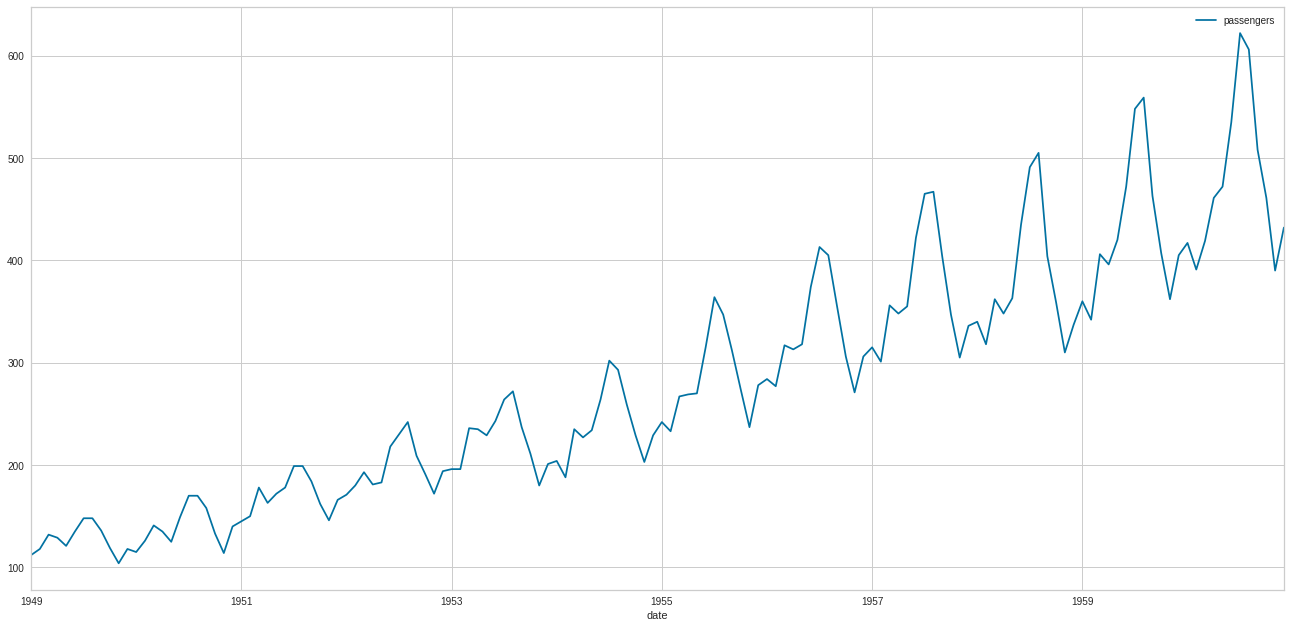

In [4]:
series['date'] = pd.to_datetime(series['date'],errors='coerce')
series.set_index('date').plot()
plt.show()

Here, this plot simple line plot. We can thinking about with this plot, the number of people who want to be an airplane passenger has increased over the years, but this number increases more significantly in certain periods every year.

## [Time Series analysis](https://www.statsmodels.org/dev/tsa.html)


statsmodels.tsa contains model classes and functions that are useful for time series analysis. Basic models include univariate autoregressive models (AR), vector autoregressive models (VAR) and univariate autoregressive moving average models (ARMA). Non-linear models include Markov switching dynamic regression and autoregression. It also includes descriptive statistics for time series, for example autocorrelation, partial autocorrelation function and periodogram, as well as the corresponding theoretical properties of ARMA or related processes. It also includes methods to work with autoregressive and moving average lag-polynomials. Additionally, related statistical tests and some useful helper functions are available.

Estimation is either done by exact or conditional Maximum Likelihood or conditional least-squares, either using Kalman Filter or direct filters.

* Currently, functions and classes have to be imported from the corresponding module, but the main classes will be made available in the statsmodels.tsa namespace. The module structure is within statsmodels.tsa is

    * stattools : empirical properties and tests, acf, pacf, granger-causality, adf unit root test, kpss test, bds test, ljung-box test and others.

    * ar_model : univariate autoregressive process, estimation with conditional and exact maximum likelihood and conditional least-squares

    * arima.model : univariate ARIMA process, estimation with alternative methods

    * statespace : Comprehensive statespace model specification and estimation. See the statespace documentation.

    * vector_ar, var : vector autoregressive process (VAR) and vector error correction models, estimation, impulse response analysis, forecast error variance decompositions, and data visualization tools. See the vector_ar documentation.

    * arma_process : properties of arma processes with given parameters, this includes tools to convert between ARMA, MA and AR representation as well as acf, pacf, spectral density, impulse response function and similar

    * sandbox.tsa.fftarma : similar to arma_process but working in frequency domain

    * tsatools : additional helper functions, to create arrays of lagged variables, construct regressors for trend, detrend and similar.

    * filters : helper function for filtering time series

    * regime_switching : Markov switching dynamic regression and autoregression models

Some additional functions that are also useful for time series analysis are in other parts of statsmodels, for example additional statistical tests.

Some related functions are also available in matplotlib, nitime, and scikits.talkbox. Those functions are designed more for the use in signal processing where longer time series are available and work more often in the frequency domain.

[sm.tsa.seasoneal_decompose()](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html#statsmodels.tsa.seasonal.seasonal_decompose)

statsmodels.tsa.seasonal.seasonal_decompose(x, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)

* This is a naive decomposition. More sophisticated methods should be preferred.

* The additive model is:

\begin{equation}
X_t = T_t + S_t + C_t + I_t \quad 
\end{equation}

* The multiplicative model is:

\begin{equation}
X_t = T_t * S_t * I_t
\end{equation}


* The results are obtained by first estimating the trend by applying a convolution filter to the data. The trend is then removed from the series and the average of this de-trended series for each period is the returned seasonal component.


* Parameters:

    * **x:** array_like

        Time series. If 2d, individual series are in columns. x must contain 2 complete cycles.
    * **model :** {“additive”, “multiplicative”}, optional

        Type of seasonal component. Abbreviations are accepted.
    * **filt :** array_like, optional

        The filter coefficients for filtering out the seasonal component. The concrete moving average method used in filtering is determined by two_sided.
    * **period :** int, optional

        Period of the series. Must be used if x is not a pandas object or if the index of x does not have a frequency. Overrides default periodicity of x if x is a pandas object with a timeseries index.
    * **two_sided :** bool, optional

        The moving average method used in filtering. If True (default), a centered moving average is computed using the filt. If False, the filter coefficients are for past values only.
    * **extrapolate_trend :** int or ‘freq’, optional

        If set to > 0, the trend resulting from the convolution is linear least-squares extrapolated on both ends (or the single one if two_sided is False) considering this many (+1) closest points. If set to ‘freq’, use freq closest points. Setting this parameter results in no NaN values in trend or resid components.

* Returns:

    * **DecomposeResult** : A object with seasonal, trend, and resid attributes.



In [5]:
# decomposition
decomposition = sm.tsa.seasonal_decompose(series["passengers"],period =12) 
decomposition_df = pd.DataFrame()
decomposition_df["seasonal_decompose"] = decomposition.seasonal
decomposition_df["trend_decompose"] = decomposition.trend
decomposition_df["residual_decompose"] = decomposition.resid
decomposition_df["date"] = series["date"]
decomposition_df["passenger"] = series["passengers"]
decomposition_df.head()

,seasonal_decompose,trend_decompose,residual_decompose,date,passenger
0,-24.748737,NaN,NaN,1949-01-01,112
1,-36.188131,NaN,NaN,1949-02-01,118
2,-2.241162,NaN,NaN,1949-03-01,132
3,-8.036616,NaN,NaN,1949-04-01,129
4,-4.506313,NaN,NaN,1949-05-01,121


#### In this module, the additive model is selected by default.

* period = interval we must set 12 for months in annual series

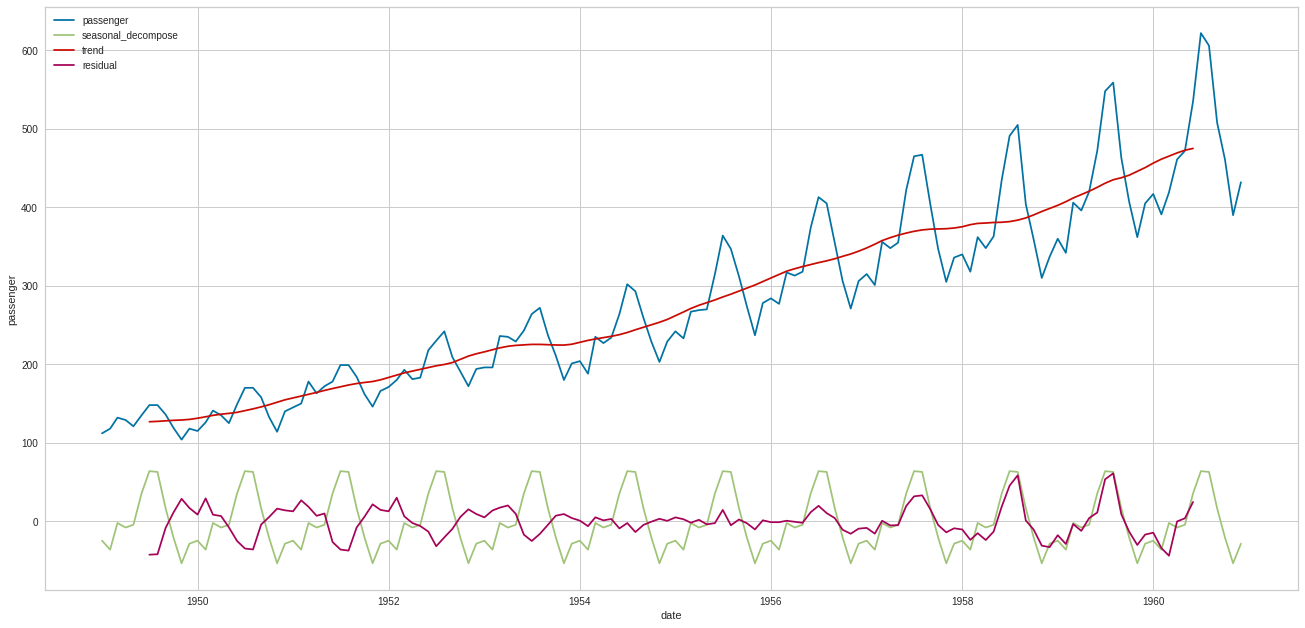

In [6]:
sns.lineplot(decomposition_df.date,decomposition_df.passenger,label="passenger")
sns.lineplot(decomposition_df.date,decomposition_df.seasonal_decompose,label="seasonal_decompose")
sns.lineplot(decomposition_df.date,decomposition_df.trend_decompose,label="trend")
sns.lineplot(decomposition_df.date,decomposition_df.residual_decompose,label="residual")
plt.show()

The most understandable graphic here was the trend. However, we have extended the work, these dataframe transformations are available in the module, but it is also possible to get values on pandas in this way.

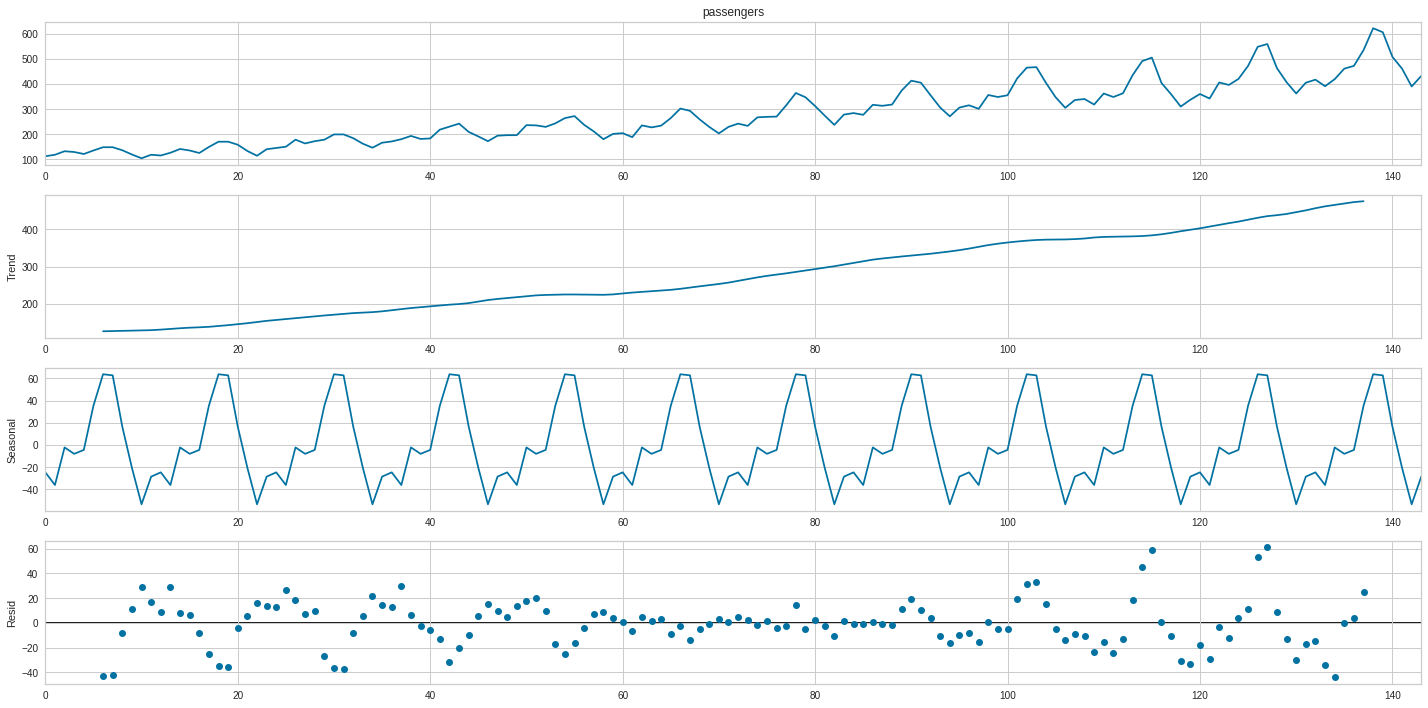

In [7]:
figure = decomposition.plot()
plt.show()

Trend and seasonality are behaving more or less in line with expectations, but the behavior of the residuals is clearly not consistent over time (average level of oscillations in the middle of the sample is very different than on either end). While there are many possible reasons, one quick explanation is the additive vs multiplicative relationship between the series components - which is something we can examine quickly:

#### multiplicative model

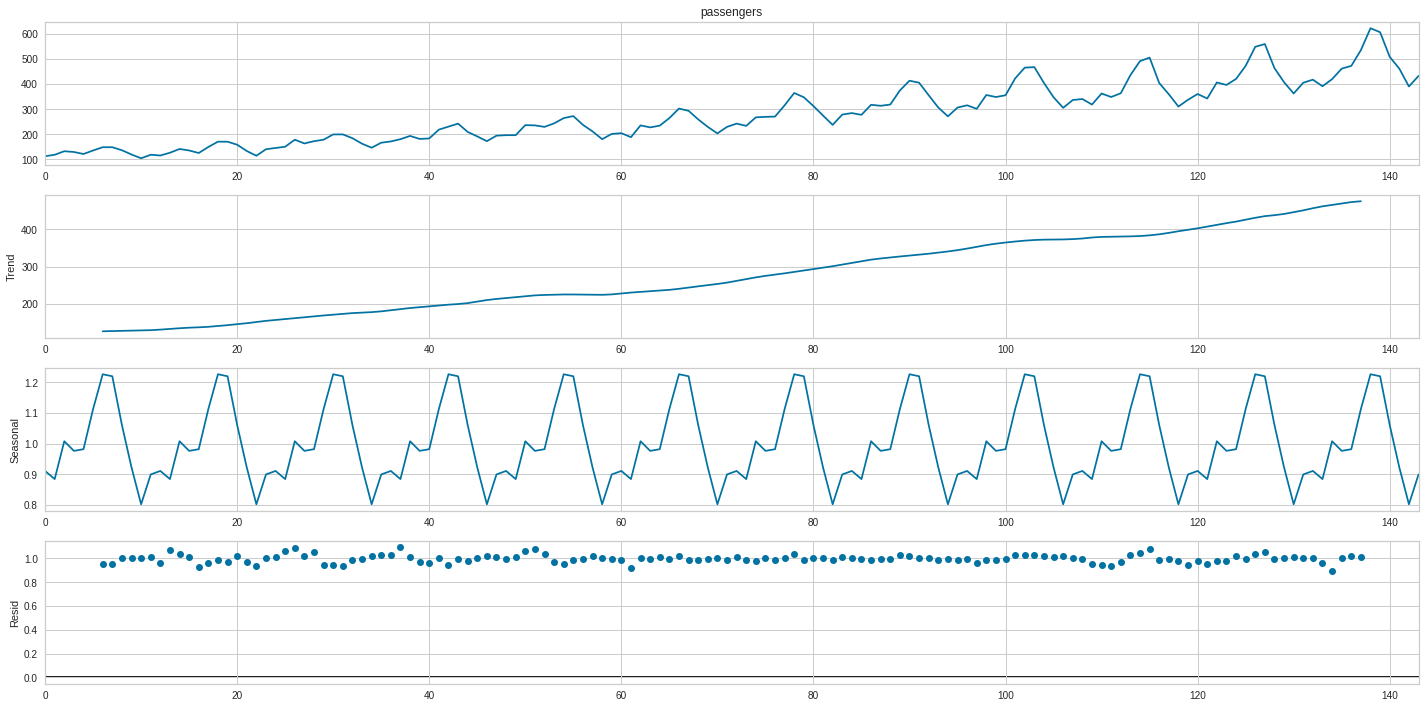

In [8]:
decomposition = sm.tsa.seasonal_decompose(series["passengers"],period =12, model = 'multiplicative') 
figure = decomposition.plot()
plt.show()

Not much of a qualitative change in trend and seasonality components, but the residuals looks much more stable around a constant level - such phenomenon does not of course imply stationarity by itself, but at least a clear signal in the opposite direction is not there anymore. BTW this dataset is stable time series.


### Changes in level of savings in the US

Let's check how does seasonal decomposition work with some other popular datasets:

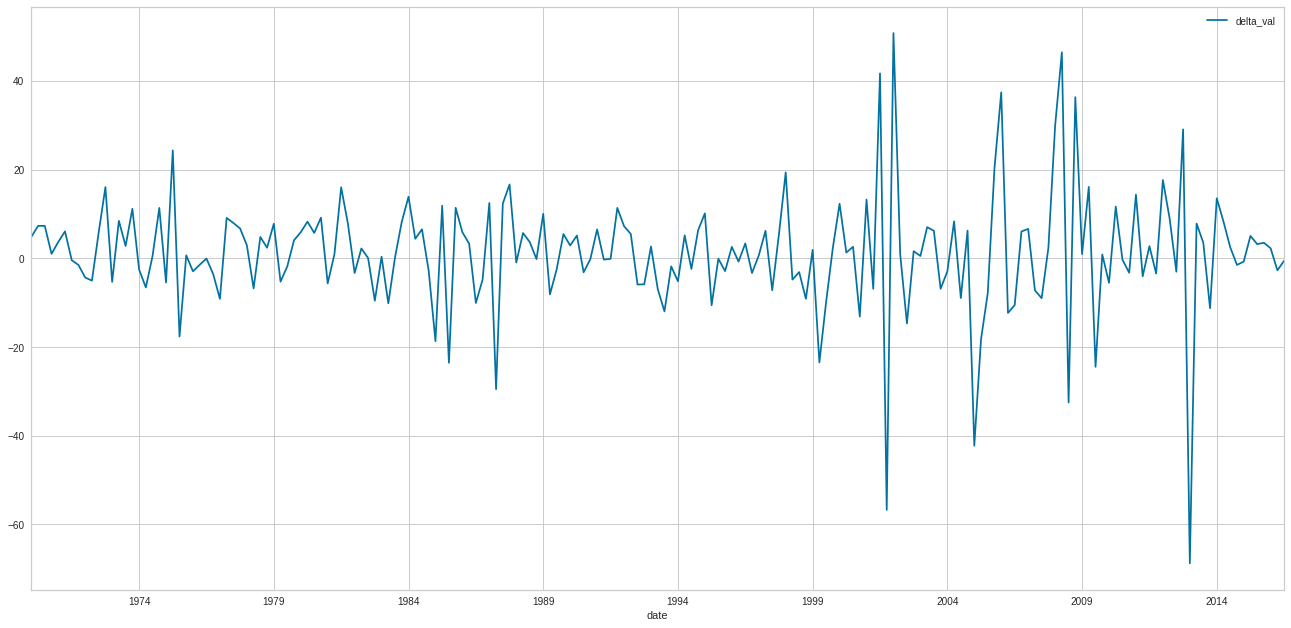

In [9]:
series = pd.read_csv(CFG.data_folder + 'savings_change.csv')
series['date'] = pd.to_datetime(series['date'])
series.set_index('date').plot()
plt.show()

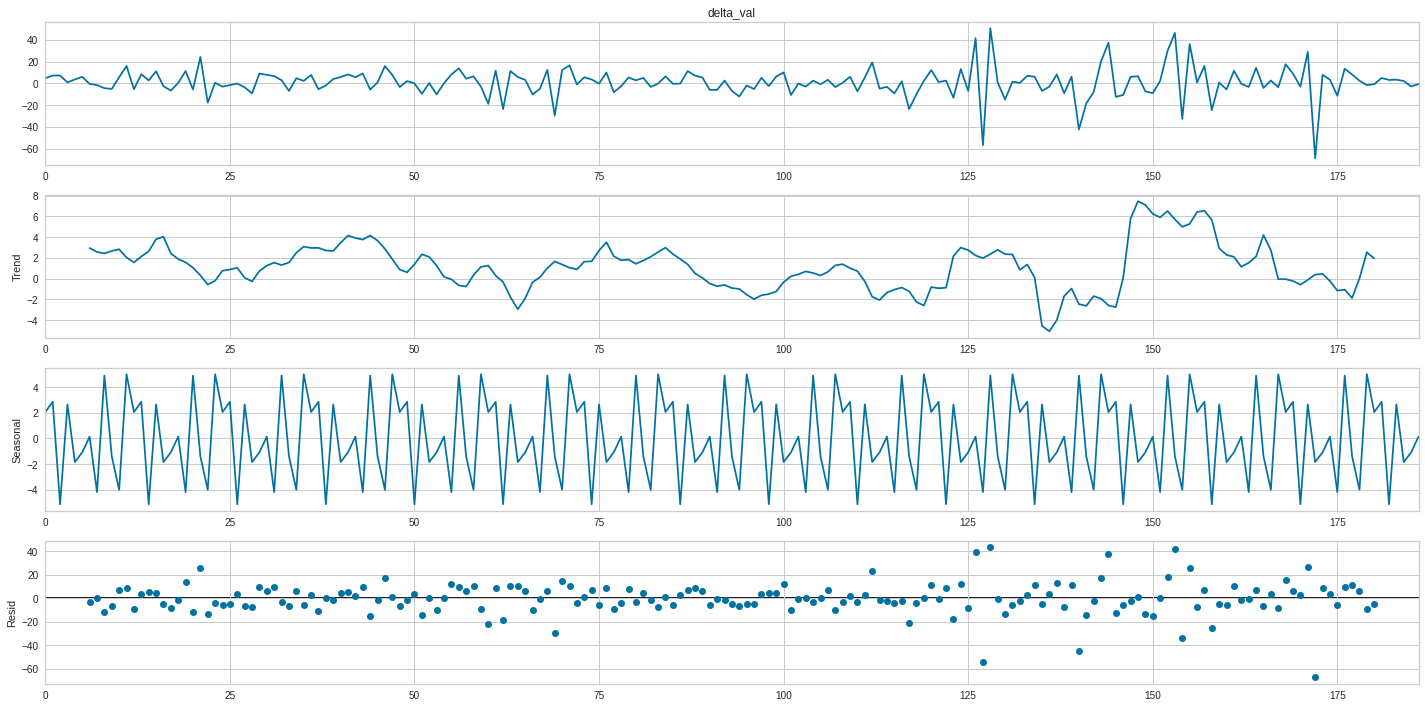

In [10]:
# decomposition
series = pd.read_csv(CFG.data_folder + 'savings_change.csv')
decomposition = sm.tsa.seasonal_decompose(series["delta_val"],period =12) 
figure = decomposition.plot()
plt.show()

### Annual averages of the daily sunspot areas

<AxesSubplot:xlabel='date'>

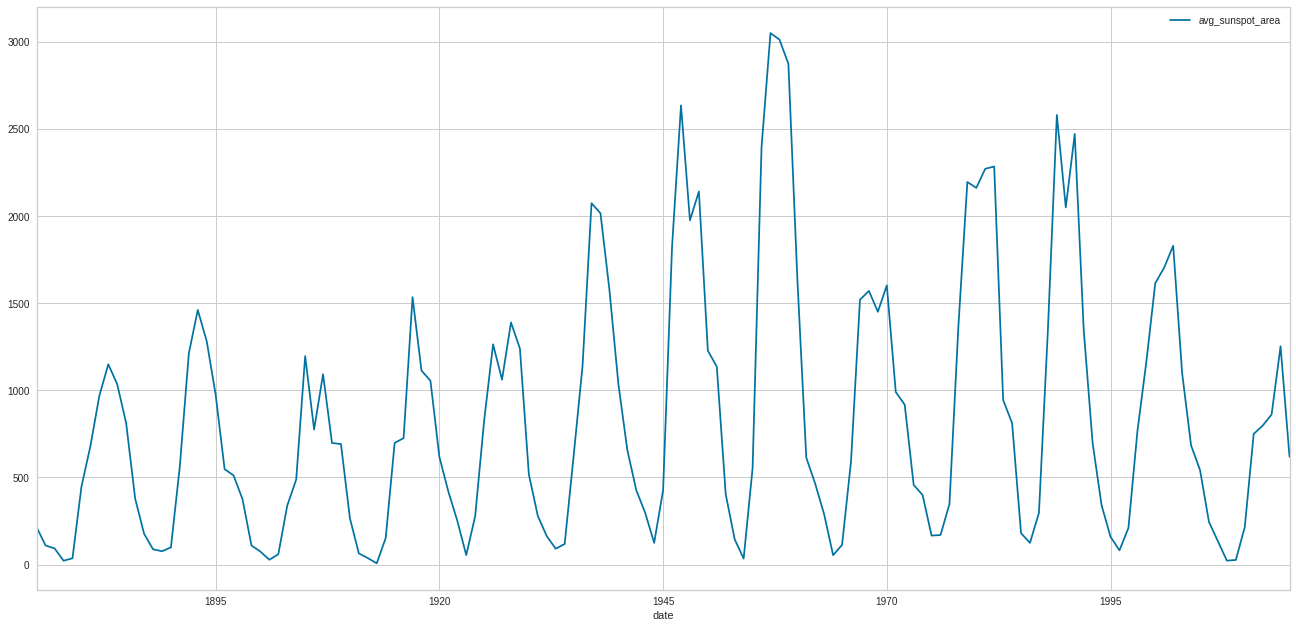

In [11]:
series = pd.read_csv(CFG.data_folder + 'sunspots.csv')
series['date'] = pd.to_datetime(series['date'])
series.set_index('date').plot()


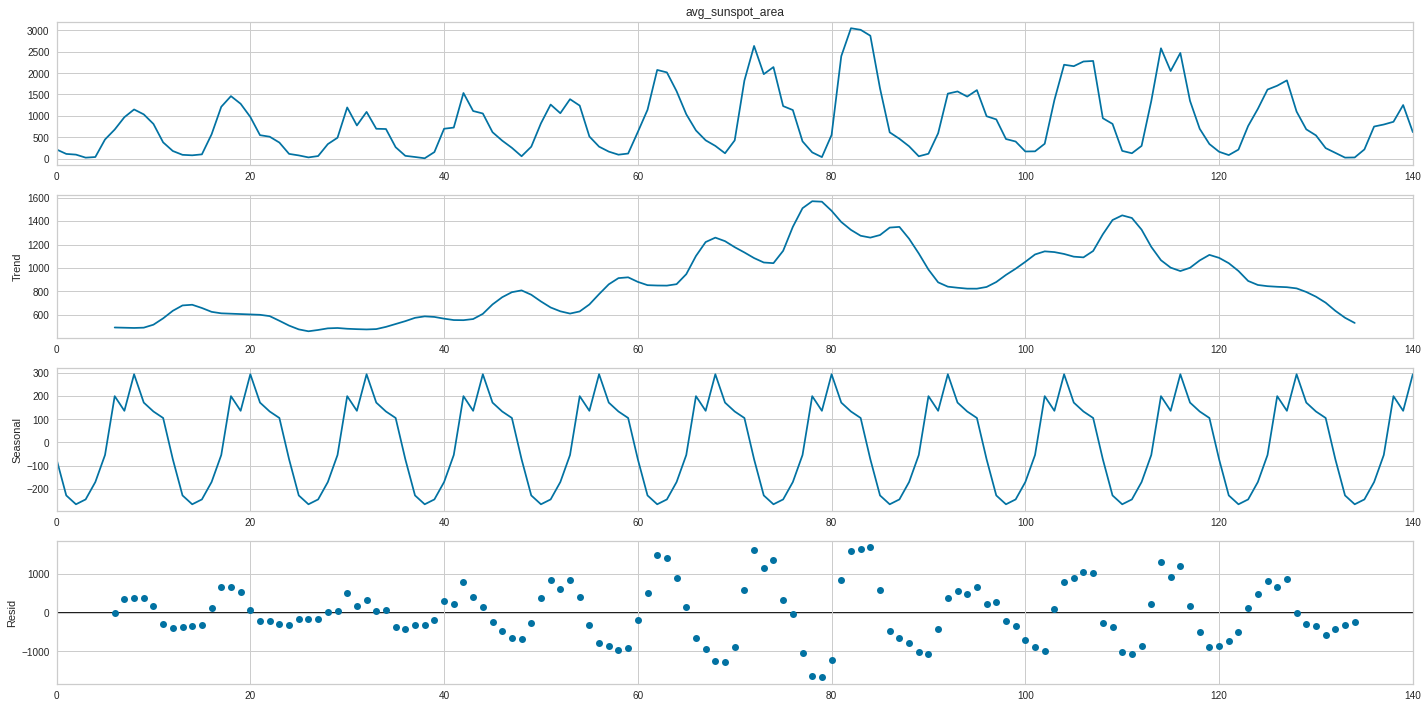

In [12]:
decomposition = sm.tsa.seasonal_decompose(series["avg_sunspot_area"],
                                                 period =12) 
figure = decomposition.plot()
plt.show()

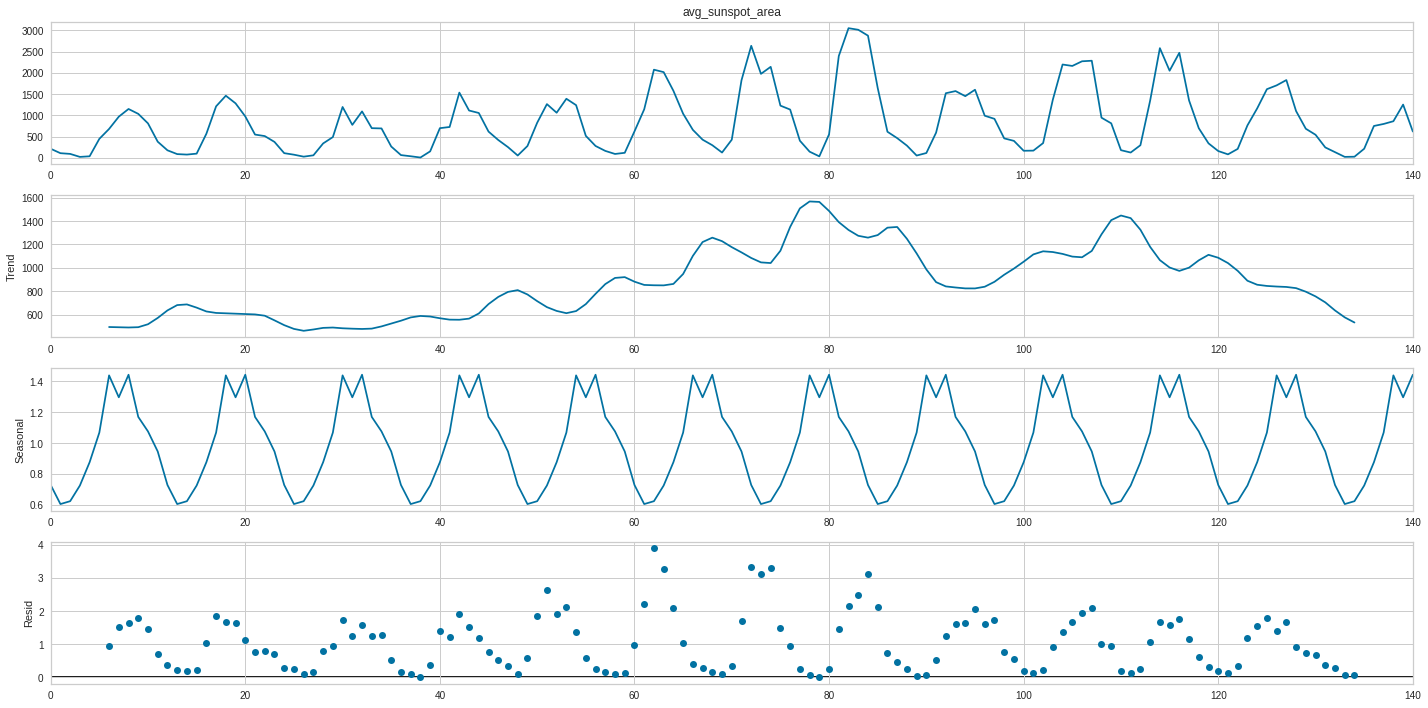

In [13]:
decomposition = sm.tsa.seasonal_decompose(series["avg_sunspot_area"],
                                          period =12, 
                                          model = 'multiplicative') 

figure = decomposition.plot()
plt.show()

As we can see, changing the decomposition type to multiplicative alleviates the problem with residual behavior, but only to a certain degree - the pattern is still not consistent, with increase in the amplitude in the middle of the sample. This demonstrates that while seasonal decomposition is a fast tool, it has severe limitations when dealing with more sophisticated data generating processes.

<a id="section-three"></a>
# Dependence

The only way to succesful prediction is if past values of a series carry some information about the future behavior - in other words, if the present values are dependent on the past. A fast - and therefore very popular - manner of examining this dependence are the autocorrelation and partial autocorrelation functions, which are defined below:

Mean function of time series:
\begin{equation}
\mu_t = E [X_t]
\end{equation}

Autocovariance function of a time series:
\begin{equation}
\gamma(s,t) = Cov(X_s, X_t) = E [X_s X_t] - E[X_s]E[X_t]
\end{equation}

which leads to the following definitions of ACF / PACF:

Autocorrelation:
\begin{equation}
\rho(u,t+u) = Cor(X_{u}, X_{t+u}) = \frac{Cov(X_t, X_{t+u})}{Var(X_t) Var(X_{t+u})}
\end{equation}



Partial autocorrelation:
\begin{equation}
\phi(u) = Cor(X_t, X_{t+u}|X_{t+1}, \ldots , X_{t+u-1})
\end{equation}



Partial autocorrelation:
\begin{equation}
\phi(u) = Cor(X_t, X_{t+u}|X_{t+1}, \ldots , X_{t+u-1})
\end{equation}

An intuitive way to think about it is that ACF at lag $k$ measures a linear dependence between $X_t$ and $X_{t+k}$, while PACF captures the dependence between those values **correcting** for all the intermediate effects. 

<a id="section-four"></a>
# Stationarity


The reason why bother with the concept in stationarity can be is best summarized with a bad joke I heard many years ago as a math student: say, a mathematician is given a piece of wood with two nails - one hammered all the way in, the other half there - and told to get remove them. How does he solve it?
1. start with the nail that's completetely in - that's the more interesting case
2. once done, hammer the other all the way - to reduce to an already solved case

I warned you it was bad - but there is an analogy to how time series theory handles the problem of nonstationarity. 

To define things more formally, a stationary time series is one whose unconditional joint probability distribution does not change when shifted in time. This implies that parameters such as mean and variance also do not change over time.

Since stationarity is an assumption underlying many statistical procedures used in time series analysis, non-stationary data are often transformed to become stationary. A trend stationary process is not strictly stationary, but can easily be transformed into a stationary process by removing the underlying trend, which is solely a function of time; the same holds true for a stationary process with an added cyclical component. 

The core idea is that it's much easier to model dynamic behavior over time if the statistical properties do not change: oscillations happen around the same level, the amplitude does not change too much etc (in other words, the probability distribution of $X_t$ is the same as the distribution of $X_{t+h}$)- such models are well understood. Algorithms are likely to yield better predictions if we apply them to stationary processes, because we do not need to worry about e.g. concept drift between our training and test sets. 


If we are dealing with a process that does not adhere to those characteristics, we can either try and capture them directly or transform it in such a manner that it can be considered stationary. 

 

[Another resource](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322)

*Why is this important? First, because stationary processes are easier to analyze. Without a formal definition for processes generating time series data (yet; they are called stochastic processes), it is already clear that stationary processes are a sub-class of a wider family of possible models of reality. This sub-class is much easier to model and investigate. The above informal definition also hints that such processes should be possible to predict, as the way they change is predictable.*

*Although it sounds a bit streetlight effect-ish that simpler theories or models should become more prominent, it is actually quite a common pattern in science, and for good reason. In many cases simple models can be surprisingly useful, either as building blocks in constructing more elaborate ones, or as helpful approximations to complex phenomena. As it turns out, this also true for stationary processes.*

*Due to these properties, stationarity has become a common assumption for many practices and tools in time series analysis. These include trend estimation, forecasting and causal inference, among others.*

*The final reason, thus, for stationarity’s importance is its ubiquity in time series analysis, making the ability to understand, detect and model it necessary for the application of many prominent tools and procedures in time series analysis. Indeed, for many cases involving time series, you will find that you have to be able to determine if the data was generated by a stationary process, and possibly to transform it so it has the properties of a sample generated by such a process.*



* Below we plot a few examples of stationary and non-stationary series, starting with the simplest non-trivial stationary series:

### Gaussian white noise.

* *Gaussian white noise (GWN) is a stationary and ergodic random process with zero mean that is defined by the following fundamental property: any two values of GWN are statis- tically independent now matter how close they are in time. The direct implication of this property is that the autocorrelation function of a GWN.*

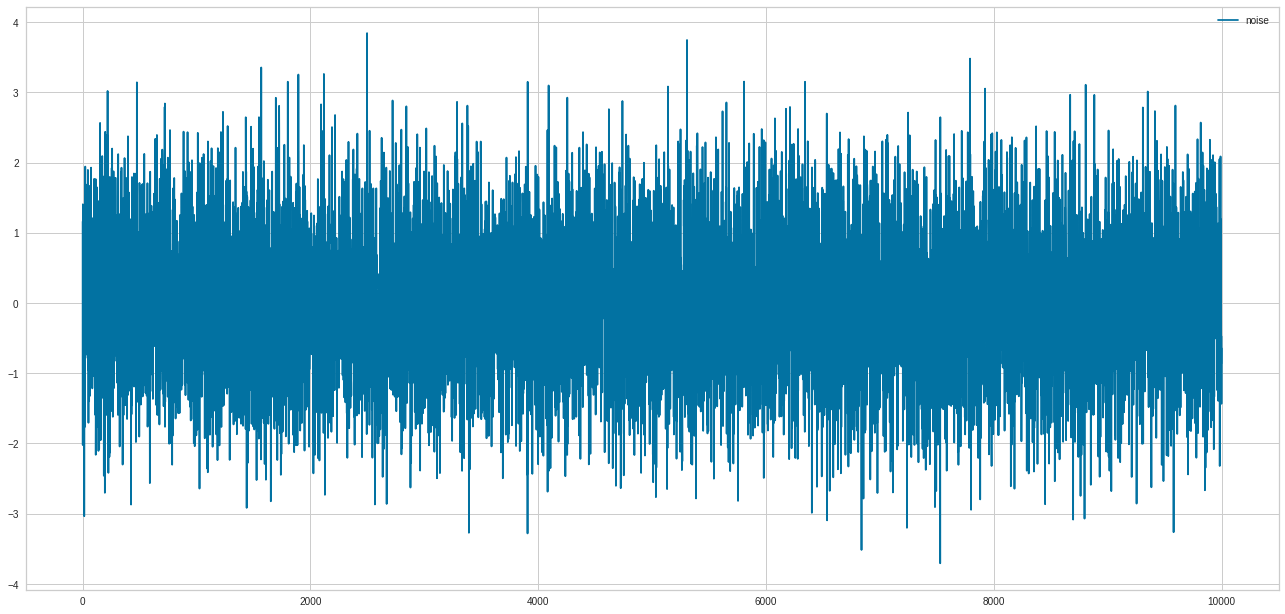

In [14]:
xseries = pd.DataFrame(data = np.random.normal(0, 1, 10000), columns = ['noise'] )
xseries.plot()
print()

## [plot_acf()](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html?highlight=plot_acf#statsmodels.graphics.tsaplots.plot_acf)

* statsmodels.graphics.tsaplots.plot_acf(x, ax=None, lags=None, *, alpha=0.05, use_vlines=True, adjusted=False, fft=False, missing='none', title='Autocorrelation', zero=True, auto_ylims=False, bartlett_confint=True, vlines_kwargs=None, **kwargs)[source]¶

    #### * Plot the autocorrelation function

    * Plots lags on the horizontal and the correlations on vertical axis.

    * **Parameters:**

        * **x:** array_like

            * Array of time-series values
        
        * **ax:** AxesSubplot, optional
        
            * If given, this subplot is used to plot in instead of a new figure being created.
        * **lags:** {int, array_like}, optional

            * An int or array of lag values, used on horizontal axis. Uses np.arange(lags) when lags is an int. If not provided, lags=np.arange(len(corr)) is used.
        * **alpha**: scalar, optional

            * If a number is given, the confidence intervals for the given level are returned. For instance if alpha=.05, 95 % confidence intervals are returned where the standard deviation is computed according to Bartlett’s formula. If None, no confidence intervals are plotted.
        * **use_vlines**: bool, optional

            * If True, vertical lines and markers are plotted. If False, only markers are plotted. The default marker is ‘o’; it can be overridden with a marker kwarg.
        * **adjusted**: bool

            * If True, then denominators for autocovariance are n-k, otherwise n
        * **fft**: bool, optional

            * If True, computes the ACF via FFT.
        * **missing**: str, optional

            * A string in [‘none’, ‘raise’, ‘conservative’, ‘drop’] specifying how the NaNs are to be treated.
        * **title**: str, optional

            * Title to place on plot. Default is ‘Autocorrelation’
        * **zero**: bool, optional

            * Flag indicating whether to include the 0-lag autocorrelation. Default is True.
        * **auto_ylims**: bool, optional

            * If True, adjusts automatically the y-axis limits to ACF values.
        * **bartlett_confint**: bool, default True

            * Confidence intervals for ACF values are generally placed at 2 standard errors around r_k. The formula used for standard error depends upon the situation. If the autocorrelations are being used to test for randomness of residuals as part of the ARIMA routine, the standard errors are determined assuming the residuals are white noise. The approximate formula for any lag is that standard error of each r_k = 1/sqrt(N). See section 9.4 of [1] for more details on the 1/sqrt(N) result. For more elementary discussion, see section 5.3.2 in [2]. For the ACF of raw data, the standard error at a lag k is found as if the right model was an MA(k-1). This allows the possible interpretation that if all autocorrelations past a certain lag are within the limits, the model might be an MA of order defined by the last significant autocorrelation. In this case, a moving average model is assumed for the data and the standard errors for the confidence intervals should be generated using Bartlett’s formula. For more details on Bartlett formula result, see section 7.2 in [1].
        * **vlines_kwargsdict**:, optional

            Optional dictionary of keyword arguments that are passed to vlines.
        * ****kwargskwargs**:, optional

            Optional keyword arguments that are directly passed on to the Matplotlib plot and axhline functions.

    * Returns:

        Figure: If ax is None, the created figure. Otherwise the figure to which ax is connected.


## [plot_pacf()](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html?highlight=plot_pacf#statsmodels.graphics.tsaplots.plot_pacf)


 * statsmodels.graphics.tsaplots.plot_pacf(x, ax=None, lags=None, alpha=0.05, method='ywm', use_vlines=True, title='Partial Autocorrelation', zero=True, vlines_kwargs=None, **kwargs)[source]¶

    #### * Plot the partial autocorrelation function

    * **Parameters**:
        * **x:** array_like
            * Array of time-series values
        * **ax**: AxesSubplot, optional

            * If given, this subplot is used to plot in instead of a new figure being created.
        * **lags**:{int, array_like}, optional

            * An int or array of lag values, used on horizontal axis. Uses np.arange(lags) when lags is an int. If not provided, * lags=np.arange(len(corr)) is used.
        * **alpha**: float, optional

            * If a number is given, the confidence intervals for the given level are returned. For instance if alpha=.05, 95 % confidence intervals are returned where the standard deviation is computed according to 1/sqrt(len(x))
        * **method** : str

            * Specifies which method for the calculations to use:

                * “ywm” or “ywmle” : Yule-Walker without adjustment. **Default**.

                * “yw” or “ywadjusted” : Yule-Walker with sample-size adjustment in denominator for acovf. Default.

                * “ols” : regression of time series on lags of it and on constant.

                * “ols-inefficient” : regression of time series on lags using a single common sample to estimate all pacf coefficients.

                * “ols-adjusted” : regression of time series on lags with a bias adjustment.

                * “ld” or “ldadjusted” : Levinson-Durbin recursion with bias correction.

                * “ldb” or “ldbiased” : Levinson-Durbin recursion without bias correction.

        * **use_vlines**:bool, optional

            * If True, vertical lines and markers are plotted. If False, only markers are plotted. The default marker is ‘o’; it can be overridden with a marker kwarg.
        * **title**: str, optional

            * Title to place on plot. Default is ‘Partial Autocorrelation’
        * **zero**: bool, optional

            * Flag indicating whether to include the 0-lag autocorrelation. Default is True.
        * **vlines_kwargsdict**:, optional

            * Optional dictionary of keyword arguments that are passed to vlines.
        * ****kwargskwargs**:, optional

            * Optional keyword arguments that are directly passed on to the Matplotlib plot and axhline functions.

    * **Returns:**

        * Figure

            * If ax is None, the created figure. Otherwise the figure to which ax is connected.




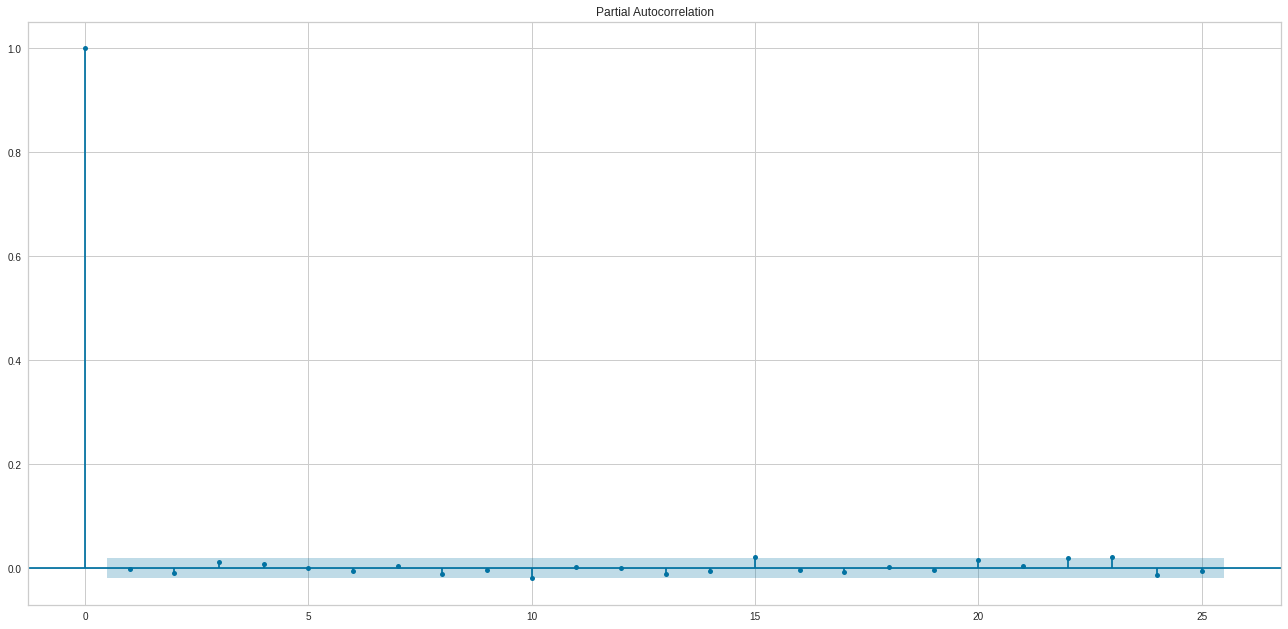

In [15]:
plot_pacf(xseries['noise'], lags = 25)
print()

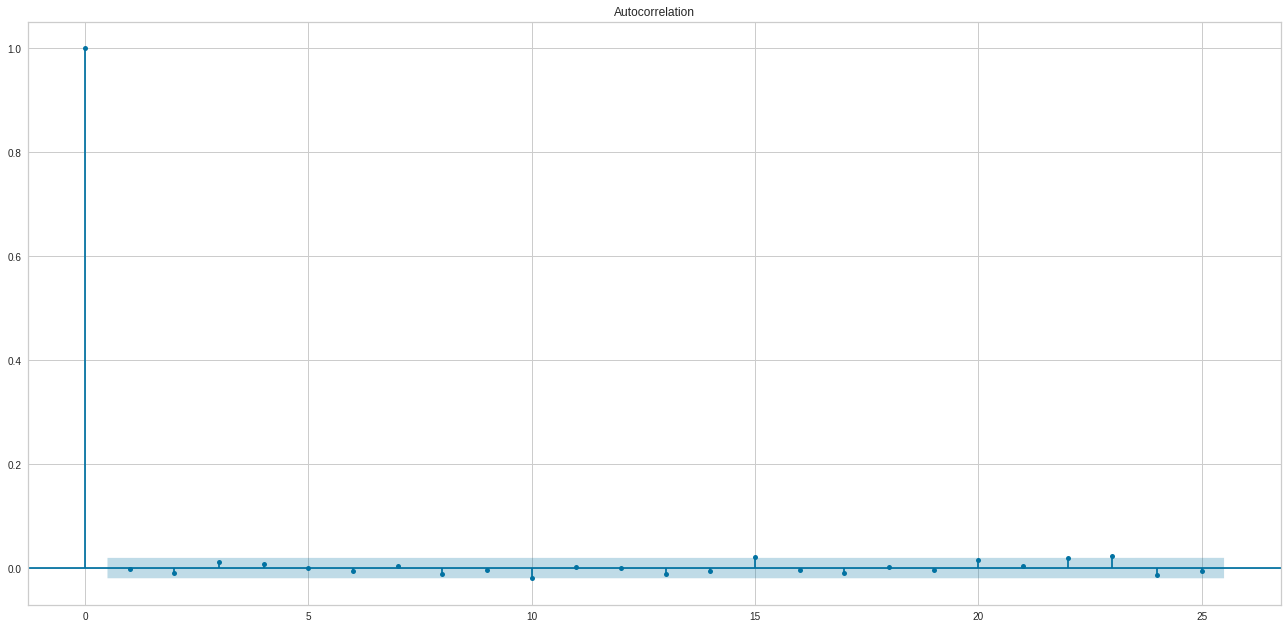

In [16]:
plot_acf(xseries['noise'], lags = 25)
print()

For a slightly more interesting example (of non-stationary behavior), we can examine the passengers dataset:

<AxesSubplot:xlabel='date'>

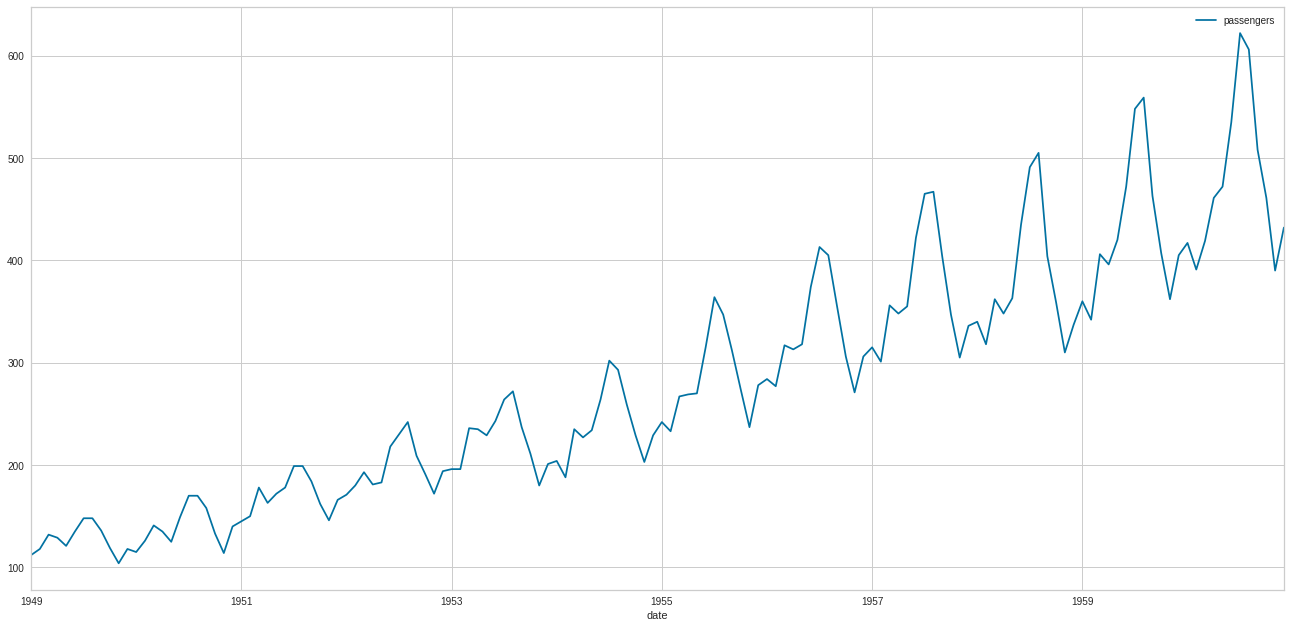

In [17]:
# Non-stationary example
series = pd.read_csv(CFG.data_folder + 'passengers.csv')
series['date'] = pd.to_datetime(series['date'])
series.set_index('date').plot()

The stationarity of a series can be checked by examining the distribution of the series: we split the series into 2 contiguous parts and compute the summary statistics like the mean, variance and the autocorrelation. If the stats are quite different, then the series is not likely to be stationary.

<AxesSubplot:ylabel='Frequency'>

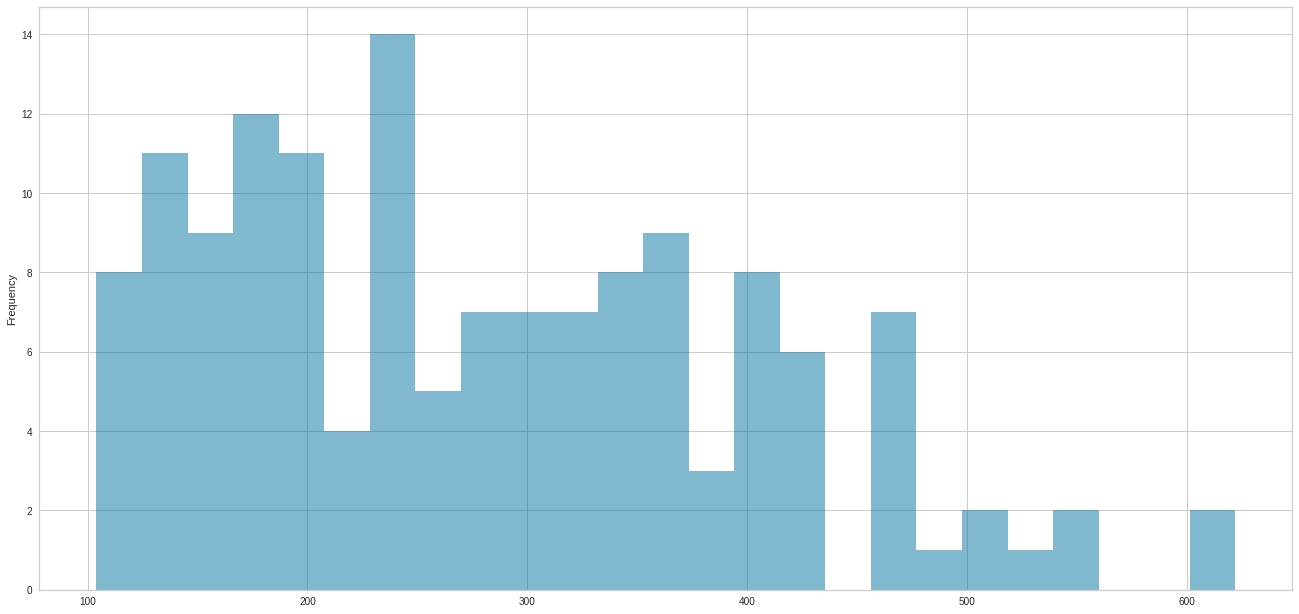

In [18]:
series = pd.read_csv(CFG.data_folder + 'passengers.csv')
series['date'] = pd.to_datetime(series['date'])
# series.set_index('date').plot()

series['passengers'].plot.hist(bins=25, alpha=0.5)


Compute the summary statistics:

In [19]:
X = series.passengers.values
split =  int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean:')
print('chunk1: %.2f vs chunk2: %.2f' % (mean1, mean2))
print('variance:')
print('chunk1: %.2f vs chunk2: %.2f' % (var1, var2))


mean:
chunk1: 182.90 vs chunk2: 377.69
variance:
chunk1: 2244.09 vs chunk2: 7367.96


The values are clearly very different across the two data subsets, which strongly suggests non-stationarity. However, visual inspection is not what one would could a rigorous criterion - so let's define things in a formal manner.

## (A little bit of) theory

Given a stochastic process $\{X_t\}$ and cdf $F_X$, a process is strictly stationary iff 

\begin{equation}
F_X(X_{t_1}, \ldots, X_{t_n}) = F_X(X_{t_1 + \tau}, \ldots, X_{t_n + \tau})
\end{equation}

The definition is very powerful (if we know a cdf of a distribution, we can infer everything) - however, it is not possible to verify in practice. For that reason, a less strict variant has been introduced: weak a.k.a. second order stationarity:

a process $\{X_t\}$ is weakly stationary if it satisfies the following conditions:

* $\mu_t = \mu_{t + \tau}$
* $\gamma(s,t) = \gamma(s-t)$
* $Var(X_t) < \infty$

Implication:
* constant mean
* covariance only depends on distance in time between variables
* autocorrelation:
\begin{equation}
\rho(u) = \frac{\gamma(u)}{\gamma(0)}
\end{equation}
    
    
So how can we turn a non-stationary series into a stationary one? Popular transformations include (but are not limited to!): 
* differencing the series 
* taking the log of the series
* power transforms 


* Lag operator of order $d$:

\begin{equation}
\nabla_d X_t = X_t - X_{t-d}
\end{equation}
    
Differencing can help stabilize the mean of a time series by removing changes in the level of a time series, and so eliminating trend and seasonality. Differencing at lag 1 is best thought of as discreet counterpart to differentiation: first derivative of a linear function is flat, first derivative of a quadratic function is linear etc - so if we want to get rid of a trend behaving like polynomial of degree $n$, we need to apply the differencing operator $n$ times. 


It is important to understand the difference between iterating diffencing operator $n$ times and differencing once at lag $n$ - which is best demonstrated in an example. 

### Tests for stationarity

While inspecting plots before / after transformation can be useful to assess presence of trends or seasonalities (as we did above with the passengers dataset), in practice we need a more formal approach - like testing a hypothesis (introduction to statistical tests is beyond the scope of this notebook, so if you feel like you need a refresher, please consult other sources). The most popular tests dealing with stationarity are: 

* Augmented Dickey-Fuller (ADF))
* Kwiatkowski–Phillips–Schmidt–Shin (KPSS)
* Philips-Perron (PP)


ADF test is a unit root test.  It determines how strongly a time series is defined by a trend. 
-  Null Hypothesis (H0): Null hypothesis of the test is that the time series can be represented by a unit root that is not stationary.
- Alternative Hypothesis (H1): Alternative Hypothesis of the test is that the time series is stationary.

Interpretation of p value:
- above $\alpha$: Accepts the Null Hypothesis (H0), the data has a unit root and is non-stationary.
- below $\alpha$ : Rejects the Null Hypothesis (H0), the data is stationary.


### ACF / PACF

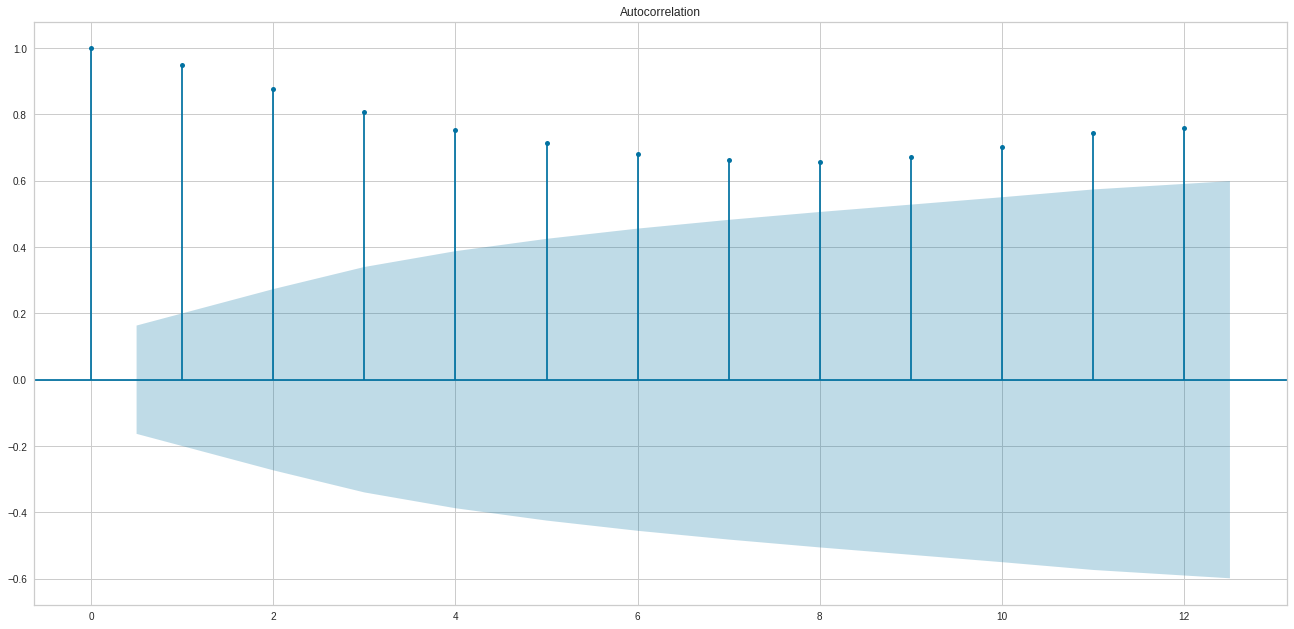

In [20]:
plot_acf(X, lags = 12)
plt.show()

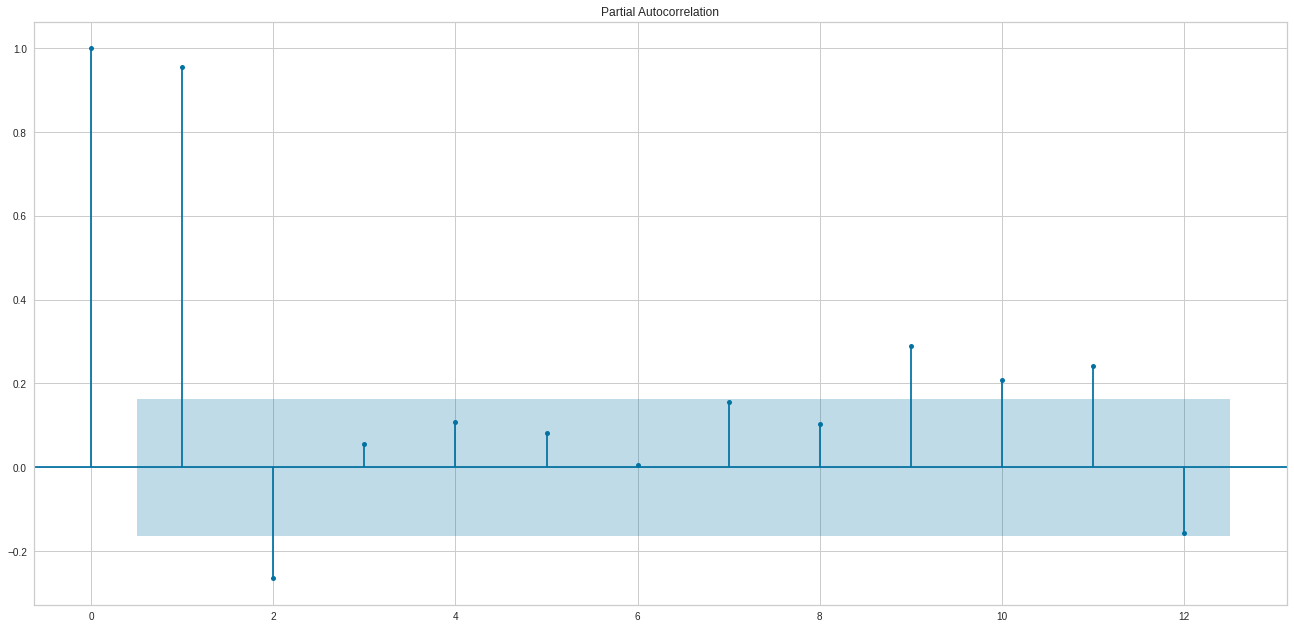

In [21]:
plot_pacf(X, lags = 12)
plt.show()

We can decompose the series to check the components one by one: which parts are responsible for the non-stationary behavior?

In [22]:
decomposition = seasonal_decompose(X, model='additive', period =12)

## [adfuller()](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html?highlight=adfuller)

* ### Augmented Dickey-Fuller unit root test.
* The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.
* **Parameters:**
    * **x:** array_like, 1d
        * The data series to test.
    * **maxlag:** {None, int}
        * Maximum lag which is included in test, default value of 12*(nobs/100)^{1/4} is used when None.
    * **regression:** {“c”,”ct”,”ctt”,”n”}
        * Constant and trend order to include in regression.
            * “c” : constant only (default).
            * “ct” : constant and trend.
            * “ctt” : constant, and linear and quadratic trend.
            * “n” : no constant, no trend.
    * **autolag**: {“AIC”, “BIC”, “t-stat”, None}
        * Method to use when automatically determining the lag length among the values 0, 1, …, maxlag.
            * If “AIC” (default) or “BIC”, then the number of lags is chosen to minimize the corresponding information criterion.
            * “t-stat” based choice of maxlag. Starts with maxlag and drops a lag until the t-statistic on the last lag length is significant using a 5%-sized test.
            * If None, then the number of included lags is set to maxlag.
    * **store**: bool
        * If True, then a result instance is returned additionally to the adf statistic. Default is False.
    * **regresults:** bool, optional
        * If True, the full regression results are returned. Default is False.
* **Returns:**
    * **adf:** float
        The test statistic.
    * **pvalue**: float
        * MacKinnon’s approximate p-value based on MacKinnon (1994, 2010).
    * **usedlag** : int
        * The number of lags used.
    * **nobs:** int
        * The number of observations used for the ADF regression and calculation of the critical values.
    * **critical values** : dict
        * Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010).
    icbestfloat
        * The maximized information criterion if autolag is not None.
    * **resstore** : ResultStore, optional
        * A dummy class with results attached as attributes.



In [36]:
result = adfuller(X)
print('ADF Statistic: %.2f' % result[0])
print('p-value: %.2f' % result[1])
print('usedlag: %.2f' % result[2])
print('nobs: %.2f' % result[3])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
print('Result_store: %.2f' % result[5])

ADF Statistic: 0.82
p-value: 0.99
usedlag: 13.00
nobs: 130.00
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Result_store: 996.69


An important caveat: it is useful to remember that statistical tests do not **accept** a hypothesis - we can only fail to reject it. 

In [24]:
# skip the start of the series: adfuller does not handle missing values which appear for values within the first full period
result = adfuller(decomposition.trend[10:-10])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.025948
p-value: 0.994532


In [34]:
result = adfuller(decomposition.seasonal[10:-10])
print('ADF Statistic: %.2f' % result[0])
print('p-value: %.2f' % result[1])

ADF Statistic: -8526301289418101.00
p-value: 0.00


In [35]:
result = adfuller(decomposition.resid[10:-10])
print('ADF Statistic: %.2f' % result[0])
print('p-value: %.2f' % result[1])

ADF Statistic: -5.03
p-value: 0.00


Summary:

- above $\alpha$: Accepts the Null Hypothesis (H0), the data has a unit root and is non-stationary.
- below $\alpha$ : Rejects the Null Hypothesis (H0), the data is stationary.
#
Default $\alpha$ is 0.05 (5%)

* trend statistic:
    * ADF Statistic: 1.025948
    * p-value: 0.994532
#    
* seasonal statistic:
    * ADF Statistic: -8526301289418101.00
    * p-value: 0.00
#
* residual statistic:
    * ADF Statistic: -5.03
    * p-value: 0.00

* As we can see, the **hypothesis of non-stationarity** is **non rejected for the trend (p>0.05)component, but not for seasonal (p<0.05)**. 
* The reason for that is that ADF test check for a very specific form of non-stationarity
* Namely variation in the presence of a linear trend (existence of a single unit root) - while the seasonal component is clearly not stationary (see graph above), it is a qualitatively different kind of behavior.

* Let's go back to our hammer-and-nail approach and try some transformations to make the series stationary.

<AxesSubplot:xlabel='date'>

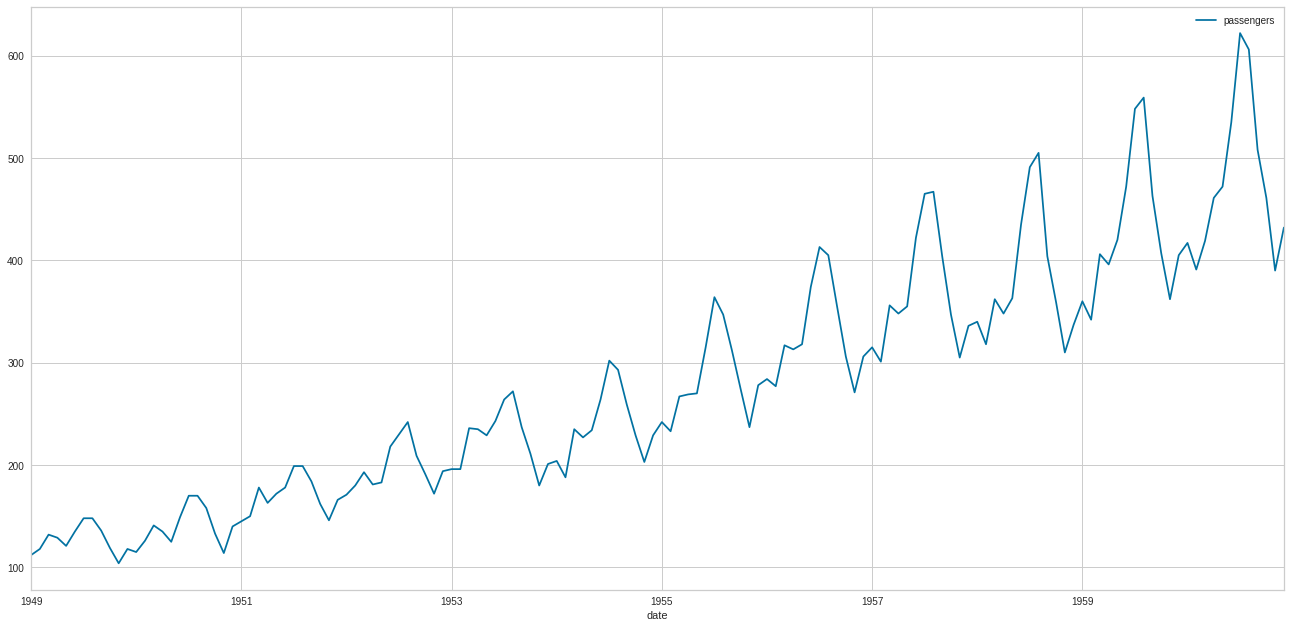

In [39]:
# Non-stationary example
series = pd.read_csv(CFG.data_folder + 'passengers.csv')
series['date'] = pd.to_datetime(series['date'])
series.set_index('date').plot()

Applying a logarithm does not remove the trend, but it does seem to stabilize the amplitude (periodic variations have comparable magnitude now). 

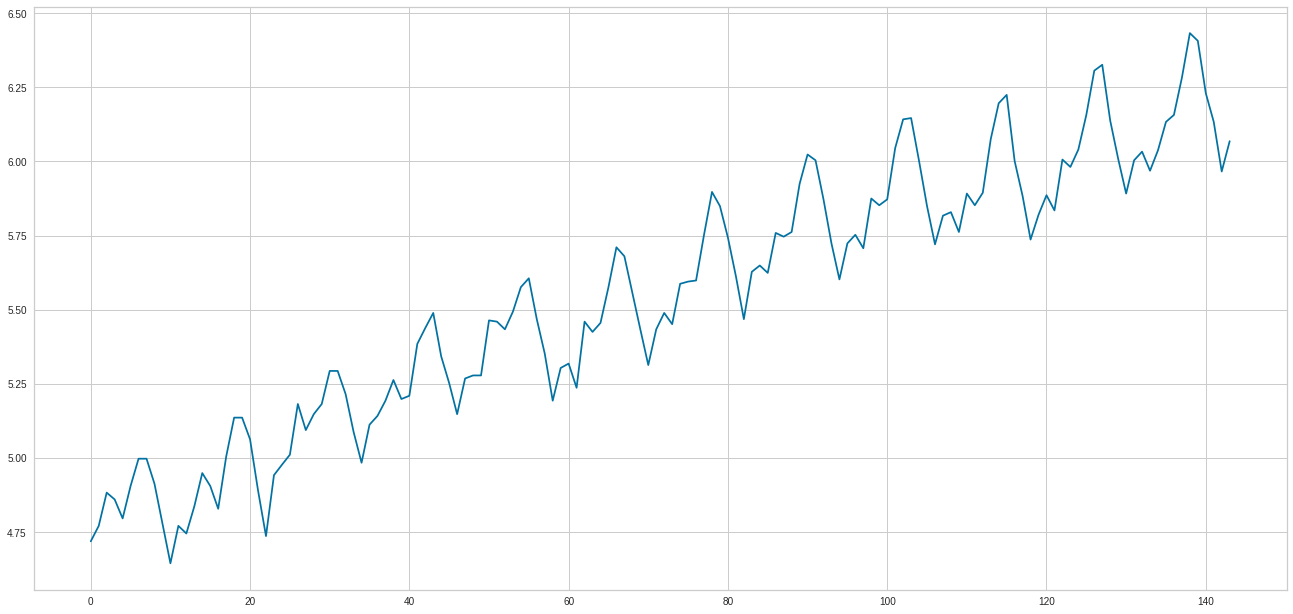

In [37]:
# np.log #

series['passengers2'] = np.log(series['passengers'])
series.passengers2.plot()
plt.show()

 How does that translate into ADF results?

In [38]:
result = adfuller(series.passengers2)
print('p-value: %.2f' % result[1])

p-value: 0.42


The null is still not rejected, but p-value has dropped - which indicates the transformations are the right way to go. Next, we can try differentiating to get rid of the trend


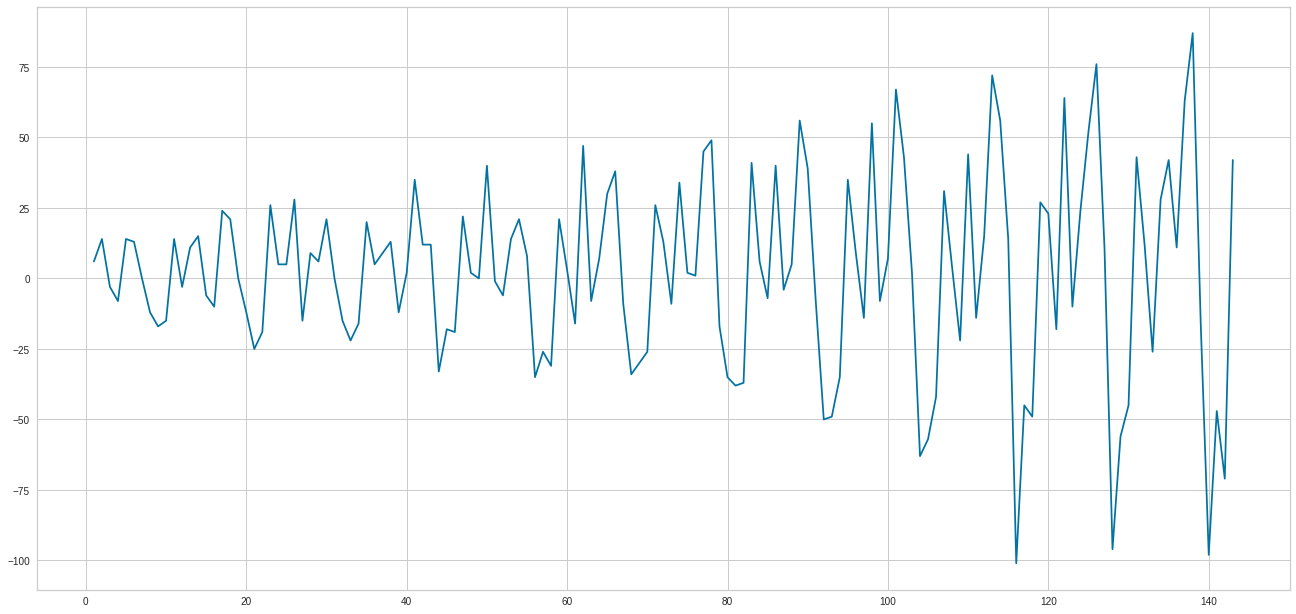

In [40]:
# pandas.DataFrame.diff() :  

# Calculates the difference of a Dataframe element compared with another element 
# in the Dataframe (default is element in previous row).
# if array = [1,2,4,7,11,16]
# array.diff() = [(2-1),(4-2),(7-3),(11-7),(16-11)] = [1,2,3,4,5]

series['passengers3'] = series['passengers'].diff()
series.passengers3.plot()
plt.show()

As expected, differentiation removes the trend (oscillations happen around a fixed level), but variations amplitude is magnified.

In [41]:
result = adfuller(series.passengers3[10:])
print('ADF Statistic: %.2f' % result[0])
print('p-value: %.2f' % result[1])

ADF Statistic: -2.83
p-value: 0.05


We continue moving in the right direction - what happens if we combine the two transformations?

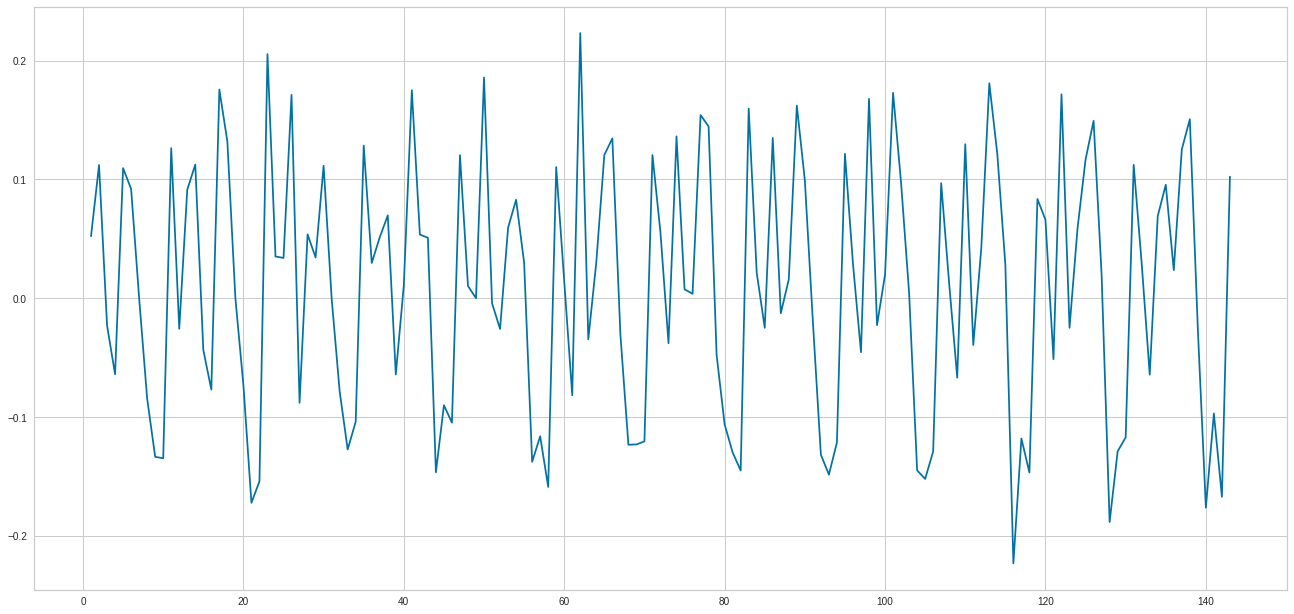

In [47]:
series['passengers4'] = series['passengers'].apply(np.log).diff()
series.passengers4.plot()
plt.show()

In [48]:
result = adfuller(series.passengers4[10:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.086110
p-value: 0.027598



So after applying logarithm (to stabilize the variance) and differentiation (to remove the trend), we have transformed our series to one that can be plausibly treated as stationary. We can verify that intuition by examining ACF and PACF:

Before

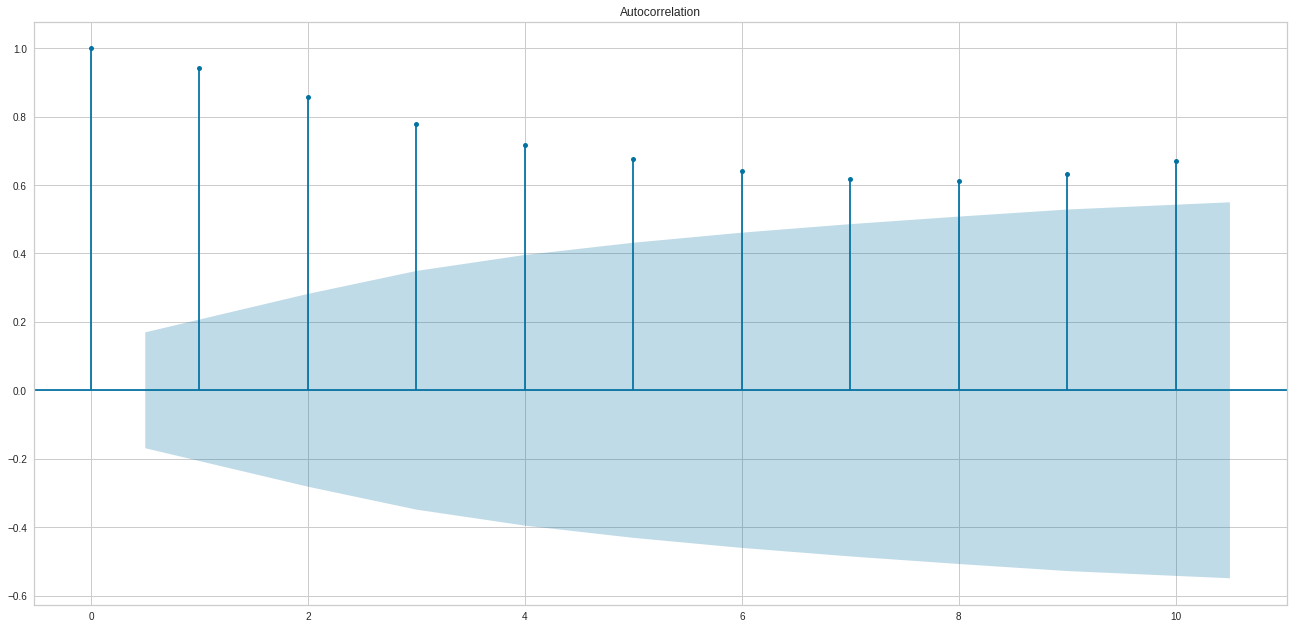

In [49]:
plot_acf(series['passengers'][10:], lags = 10)
plt.show()

After

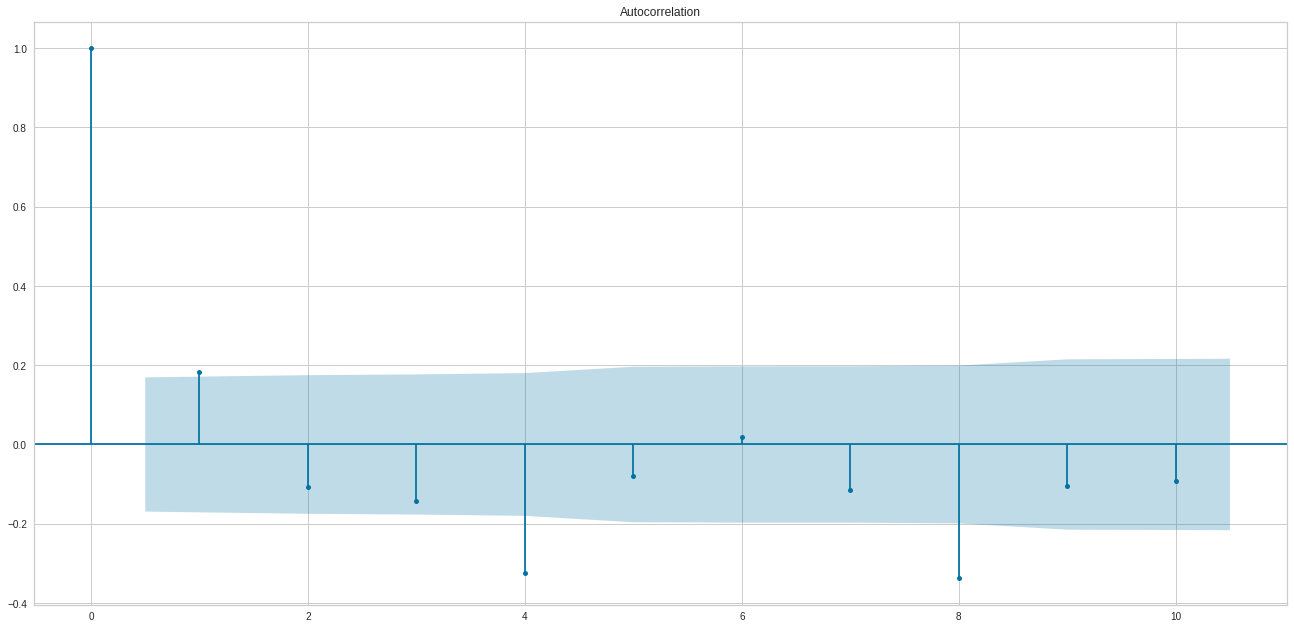

In [51]:
plot_acf(series['passengers4'][10:], lags = 10)
plt.show()

Before

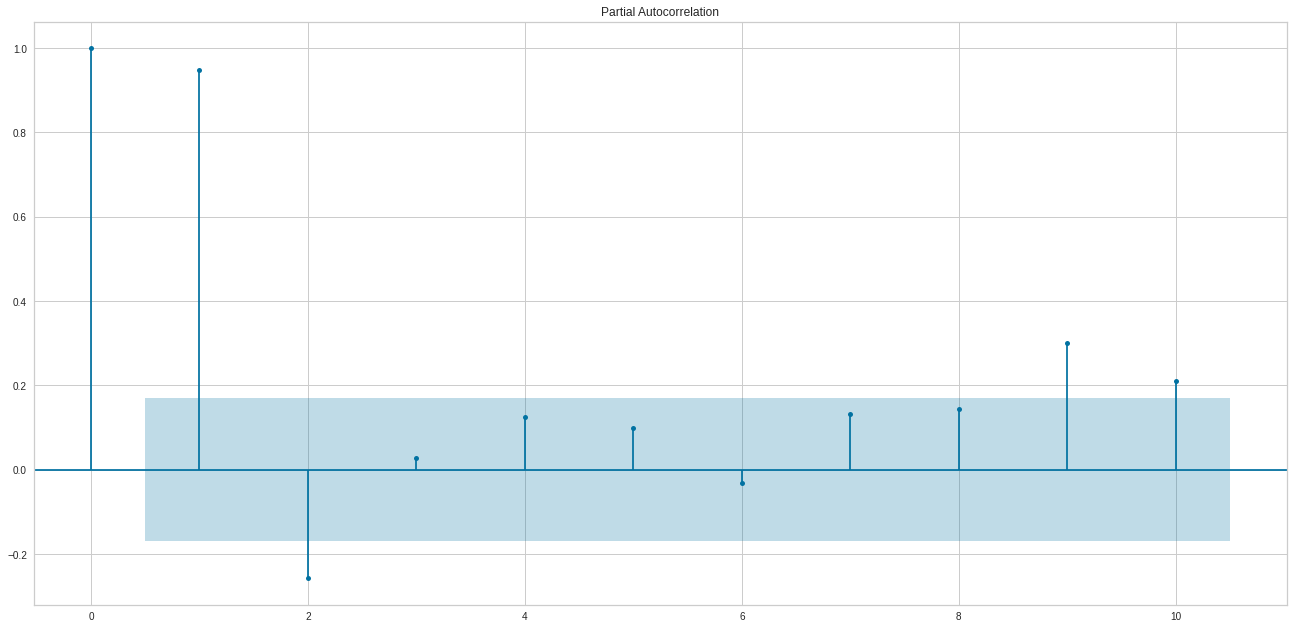

In [52]:
plot_pacf(series['passengers'][10:], lags = 10)
plt.show()

After

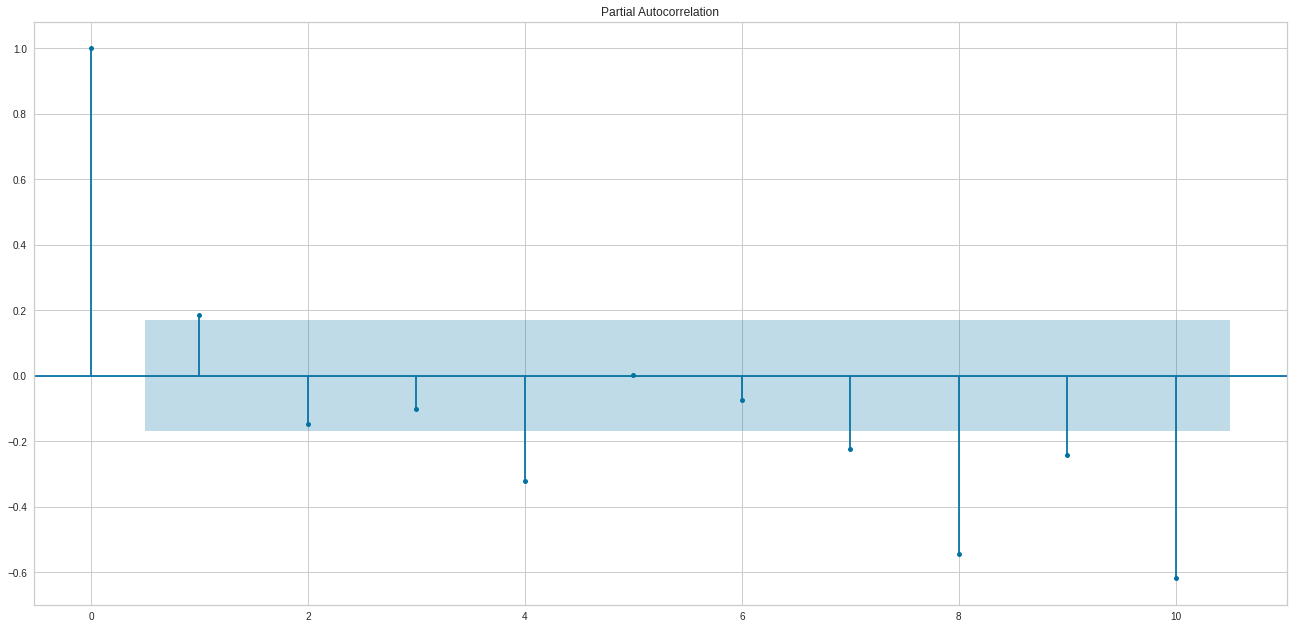

In [53]:
plot_pacf(series['passengers4'][10:], lags = 10)
plt.show()

*[Next lesson](https://github.com/turkalpmd/time_series/blob/master/code/TS-1a:%20smoothing%20methods.ipynb)*